In [2]:
import numpy as np
from numpy import exp
import matplotlib.pyplot as plt
from scipy.optimize import minimize,root
from scipy.integrate import quad
import pandas as pd
import tikzplotlib
plt.rcParams['text.usetex'] = True
np.set_printoptions(precision=4)

In [3]:
fb, fc = 2, 8
rho = 200.
R = 10.0;  beta = 20; H=12/60
vb,vc,vw = 25.0,30.,3.0;
gamma = 40/3600;
theta = 4/3600;
U = lambda s,q: 1./vb+gamma/s + H*q*theta/R
T = lambda x, s, q: s/2/vw + H/2+x*U(s,q)
Vb = lambda t: -beta*t - fb 
Vw = lambda x: -beta*x/vw
Vc = lambda x: -beta*x/vc - fc
Vs = lambda t,x: exp(Vw(x)) + exp(Vc(x)) + exp(Vb(t))
Dw = lambda t,x: exp(Vw(x))/Vs(t,x)
Dc = lambda t,x: exp(Vc(x))/Vs(t,x)
Db = lambda t,x: exp(Vb(t))/Vs(t,x)
B = lambda s: R*U(s,Q(s))/H

def Q(s):
    return root(lambda Q: quad(lambda x: rho*Db(T(x, s, Q[0]), x), 0, R)[0] - Q[0], x0=rho/2).x[0]
def K(s):
    q = Q(s)
    return quad(lambda x: rho*x*Db(T(x,s,q), x), 0, R)[0]
def Qc(s):
    Qb = Q(s)
    return quad(lambda x: rho*Dc(T(x,s,Qb),x),0,R)[0]
def Qw(s):
    Qb = Q(s)
    return quad(lambda x: rho*Dw(T(x,s,Qb),x),0,R)[0]
Qc, Qw, Q, K = [np.vectorize(x) for x in (Qc,Qw,Q,K)] 
sQ = minimize(lambda x: -Q(x), R/5,  bounds=[(0.001, R)]).x[0]
sK = minimize(lambda x: -K(x), R/5, bounds=[(0.001, R)]).x[0]
sarr = np.array([0.3,sQ,sK])
df = pd.DataFrame({
    's':sarr*1000,
   'Q': Q(sarr), 
    'K': K(sarr),
    'xbar':K(sarr)/Q(sarr),
    'U':U(sarr,Q(sarr))*60,
    'H': np.ones(sarr.size)*H*60,
    'B': B(sarr),
    'R/B':R/B(sarr),
    'L': K(sarr)*H/R,
}).round({'s':0, 'Q':0,'K':0,'xbar':2,'U':2,'B':2, 'L': 1, 'H': 2,'R/B':2})
print(df.to_latex(index=False))
df

\begin{tabular}{rrrrrrrrr}
\toprule
    s &     Q &      K &  xbar &    U &    H &    B &  R/B &    L \\
\midrule
300.0 & 400.0 & 1004.0 &  2.51 & 5.16 & 12.0 & 4.30 & 2.33 & 20.1 \\
475.0 & 445.0 & 1292.0 &  2.91 & 4.40 & 12.0 & 3.66 & 2.73 & 25.8 \\
583.0 & 434.0 & 1329.0 &  3.06 & 4.12 & 12.0 & 3.44 & 2.91 & 26.6 \\
\bottomrule
\end{tabular}



,s,Q,K,xbar,U,H,B,R/B,L
0,300.0,400.0,1004.0,2.51,5.16,12.0,4.30,2.33,20.1
1,475.0,445.0,1292.0,2.91,4.40,12.0,3.66,2.73,25.8
2,583.0,434.0,1329.0,3.06,4.12,12.0,3.44,2.91,26.6


Text(0.5, 0, '$s$ (km/stop)')

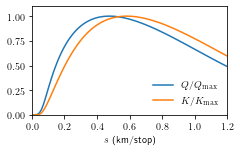

In [52]:
fig,ax = plt.subplots(figsize=(3.5,2))
sarr = np.linspace(0.01, 1.2, 100)
Qarr = Q(sarr)
Karr = K(sarr)
ax.plot(sarr, Qarr/max(Qarr), label  = r'$Q/Q_{\max}$')
ax.plot(sarr, Karr/max(Karr), label  = r'$K/K_{\max}$')
ax.set_xlim(0, sarr[-1])
ax.set_ylim(0, 1.1)
ax.legend(frameon=False)
ax.set_xlabel(r'$s$ (km/stop)')
# tikzplotlib.save('qk-boarding.tex',figure=fig,standalone=True,axis_width='8cm',axis_height='5cm')

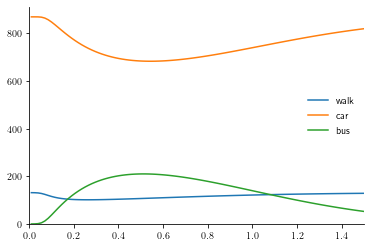

In [5]:
fig,ax = plt.subplots()
sarr = np.linspace(0.01, 1.5, 100)
for (fun,mode) in [(Qw,'walk'),(Qc,'car'),(Q,'bus')]:
    ax.plot(sarr,fun(sarr),label=mode)

ax.set_xlim(0,sarr[-1]);ax.set_ylim(0,ax.get_ylim()[1])
ax.legend(frameon=False);ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)

0.00576424977898714


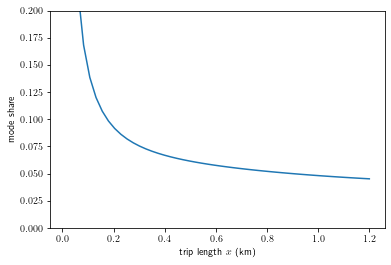

In [10]:
fig,ax = plt.subplots()
U = lambda s, q: 1/vb + gamma/s + H*q*theta/R
ss = np.linspace(.01,1.2,50)
qs = Q(ss)
ax.plot(ss,U(ss,qs))
ax.set_ylim([0,.2])
ax.set_ylabel(r"mode share"); 
ax.set_xlabel(r"trip length $x$ (km)")
print(H*Q(sK)/R*theta)